## 1. Setup and Imports

In [1]:
import sys
import os

# Add the src directory to the path so we can import malthusjax
sys.path.append('/Users/leonardodicaterina/Documents/GitHub/MalthusJAX/src')

import jax
import jax.numpy as jnp
import jax.random as jar
import matplotlib.pyplot as plt

from malthusjax.core.genome import BinaryGenome
from malthusjax.core.fitness.binary_ones import BinarySumFitnessEvaluator
from malthusjax.core.population.population import AbstractPopulation
from malthusjax.operators.crossover.binary import UniformCrossover, CycleCrossover, SinglePointCrossover,PillarCrossover


In [2]:
def crossover(genome_data1: jax.Array, genome_data2: jax.Array, random_key: jax.Array) -> jax.Array:
    """Perform pillar point crossover on two genomes."""
    length = genome_data1.shape[0]
    indices = jnp.arange(length)
    
    # Create mask where genomes are equal
    mask = genome_data1 == genome_data2
    
    # Create permuted indices for shuffling
    perm_indices = jax.random.permutation(random_key, indices)
    
    # Create the output array starting with genome_data1
    output = genome_data1
    
    # Function to update a single index
    def update_fn(i, val):
        should_update = ~mask[i]
        # Find the corresponding permuted value
        perm_idx = perm_indices[i]
        new_val = jnp.where(should_update, genome_data1[perm_idx], val)
        return new_val
    
    # Apply updates using scan to avoid dynamic indexing
    output = jax.lax.fori_loop(0, length, 
                              lambda i, acc: acc.at[i].set(update_fn(i, acc[i])), 
                              output)
    
    return output

test_key = jar.PRNGKey(42)
genome1 = BinaryGenome(array_size=8, p=0.5, random_key=jar.PRNGKey(1), random_init=True).to_tensor()
genome2 = BinaryGenome(array_size=8, p=0.5, random_key=jar.PRNGKey(2), random_init=True).to_tensor()
crossed = crossover(genome1, genome2, test_key)
print(f"Genome 1: {genome1}")
print(f"Genome 2: {genome2}")
print(f"Crossed:  {crossed}")
# crossover jitted
crossover_jit = jax.jit(crossover)
crossed_jit = crossover_jit(genome1, genome2, test_key)
print(f"Crossed jit:  {crossed_jit}")


Genome 1: [1 0 1 1 0 0 1 1]
Genome 2: [0 0 1 0 1 0 0 1]
Crossed:  [1 0 1 0 1 0 1 1]
Crossed jit:  [1 0 1 0 1 0 1 1]


In [3]:
def crossover(genome_data1: jax.Array, genome_data2: jax.Array, random_key: jax.Array) -> jax.Array:  # Only 2 args
    """Perform cycle crossover on a single genome.
    
    Args:
        genome_data1: Input genome array 
        genome_data2: Second genome array for crossover
        random_key: JAX random key for stochastic operations 
        
    Returns:
        Modified genome after crossover
    """
    start_pos = jar.randint(random_key, (), 0, genome_data1.shape[0])
    def body_fun(carry, _):
        idx, offspring = carry
        next_idx = jnp.where(genome_data1 == genome_data2[idx], size=1)[0][0]
        new_offspring = offspring.at[next_idx].set(genome_data2[next_idx])
        return (next_idx, new_offspring), None
    
    
    initial_offspring = genome_data1.at[start_pos].set(genome_data2[start_pos])
    (_, final_offspring), _ = jax.lax.scan(
        lambda c, x: body_fun(c, x),
        (start_pos, initial_offspring),
        jnp.arange(genome_data1.shape[0]),
    )
    
    return final_offspring
# Parameters
gen1 = jnp.array([1, 0, 1, 1, 0, 0, 1, 0])
gen2 = jnp.array([0, 1, 0, 0, 1, 1, 0, 1])
key = jar.PRNGKey(42)

# Perform crossover
result = crossover(gen1, gen2, key)
print("Parent 1: ", gen1)
print("Parent 2: ", gen2)
print("Crossover Result: ", result)

# jit compile the function
crossover_jit = jax.jit(crossover)
result_jit = crossover_jit(gen1, gen2, key)
print("JIT Crossover Result: ", result_jit)

pop1 = AbstractPopulation(
    genome_cls=BinaryGenome,
    genome_init_params={'array_size': 8, 'p': 0.5},
    pop_size=5,
    random_init=True,
    random_key=jar.PRNGKey(0)

)
pop2 = AbstractPopulation(
    genome_cls=BinaryGenome,
    genome_init_params={'array_size': 8, 'p': 0.5},
    pop_size=5,
    random_init=True,
    random_key=jar.PRNGKey(1)
)

pop1_stack = pop1.to_stack()
pop2_stack = pop2.to_stack()

# Vectorized crossover function
def vectorized_crossover(pop1_stack: jax.Array, random_keys: jax.Array) -> jax.Array:
    #shuffle the second population to create pairs
    pop2_stack = jax.random.permutation(random_keys[0], pop1_stack, axis=0)
    return jax.vmap(crossover)(pop1_stack, pop2_stack, random_keys)

random_keys = jar.split(jar.PRNGKey(42), pop1_stack.shape[0])
crossed_population_stack = vectorized_crossover(pop1_stack, random_keys)
print("Population 1:\n", pop1_stack)
print("Crossed Population:\n", crossed_population_stack)

Parent 1:  [1 0 1 1 0 0 1 0]
Parent 2:  [0 1 0 0 1 1 0 1]
Crossover Result:  [0 1 1 1 1 0 1 0]
JIT Crossover Result:  [0 1 1 1 1 0 1 0]
Population 1:
 [[False  True  True  True  True False False  True]
 [ True  True False  True  True  True  True False]
 [False False  True  True False False False  True]
 [ True False False  True  True False False  True]
 [ True False  True  True  True  True False False]]
Crossed Population:
 [[False  True  True  True  True False False  True]
 [ True  True False  True  True False  True False]
 [False  True  True  True False False False  True]
 [ True False False  True  True False False  True]
 [ True False  True  True  True  True False False]]


## 2. BitFlipMutation: Introducing Genetic Variation
The BitFlipMutation operator randomly flips bits (0 to 1, or 1 to 0) in a binary genome with a specified probability. This introduces new genetic material into the population, preventing premature convergence.

#### Initialization
You can initialize BitFlipMutation with a default mutation rate (0.01) or a custom rate

In [4]:
crossover_default = UniformCrossover()
print(f"Default Crossover Rate: {crossover_default.crossover_rate}")

# Custom initialization
custom_crossover_rate = 0.5
crossover_instance = PillarCrossover(crossover_rate=custom_crossover_rate)

print(f"Custom Crossover Rate: {crossover_instance.crossover_rate}")



pop_size = 5
genome_init_params = {'array_size': 10, 'p': 0.5}
population = AbstractPopulation(
    genome_cls=BinaryGenome,
    pop_size=pop_size,
    random_init=True,
    random_key=jar.PRNGKey(10),
    genome_init_params=genome_init_params,
)
crossed_population = crossover_instance(population)



Default Crossover Rate: 0.01
Custom Crossover Rate: 0.5


Text(0, 0.5, 'Individual Index')

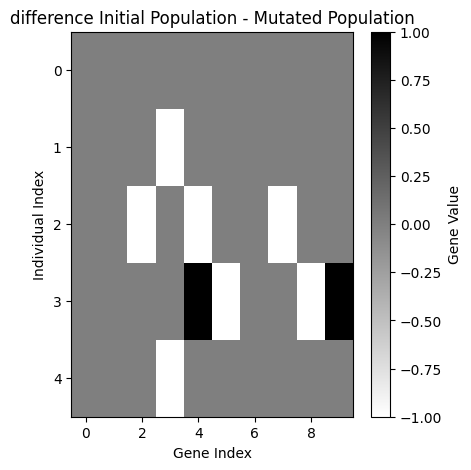

In [5]:
initial_population_stack = population.to_stack().astype(jnp.int32)
mutated_population_stack = crossed_population.to_stack().astype(jnp.int32)

#heatmap of initial population - mutation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("difference Initial Population - Mutated Population")
plt.imshow(initial_population_stack - mutated_population_stack, cmap='binary', aspect='auto')
plt.colorbar(label='Gene Value')
plt.xlabel('Gene Index')
plt.ylabel('Individual Index')  

In [6]:
single_mutation_fn = crossover_instance.get_compiled_function()
single_genome1 = BinaryGenome(**genome_init_params, random_init= True, random_key=jar.PRNGKey(0))
single_genome2 = BinaryGenome(**genome_init_params, random_init= True, random_key=jar.PRNGKey(1))

first_cross = single_mutation_fn(single_genome1.to_tensor(), 
                                 single_genome2.to_tensor(),
                                 jar.PRNGKey(42))

In [7]:
print(f"difference Single Genome1 - First Cross:\n {single_genome1.to_tensor() - first_cross}")
print(f"difference Single Genome2 - First Cross:\n {single_genome2.to_tensor() - first_cross}")


difference Single Genome1 - First Cross:
 [0 0 0 0 0 0 0 0 0 0]
difference Single Genome2 - First Cross:
 [ 0 -1  1  0 -1 -1  0  1  0  0]


In [8]:
# testing batched finction
batched_mutation_fn = crossover_instance.get_batched_function()
population = AbstractPopulation(
    genome_cls=BinaryGenome,
    genome_init_params=genome_init_params,
    pop_size=10,
    random_key=jar.PRNGKey(42),
    random_init=True )


mutated_population = batched_mutation_fn(
    population.to_stack(),
    jar.split(
        jar.PRNGKey(42),
        len(population)
    )
)


Text(0, 0.5, 'Individual Index')

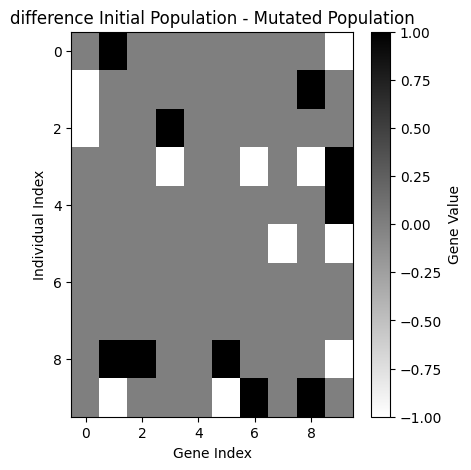

In [9]:
initial_population_stack = population.to_stack().astype(jnp.int32)
mutated_population_stack = mutated_population.astype(jnp.int32)

#heatmap of initial population - mutation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("difference Initial Population - Mutated Population")
plt.imshow(initial_population_stack - mutated_population_stack, cmap='binary', aspect='auto')
plt.colorbar(label='Gene Value')
plt.xlabel('Gene Index')
plt.ylabel('Individual Index') 